### Retrieve historical and projected tasmin from NEX-GDDP-CMIP6 for existing orchards.

using 10 years of data to start out

In [2]:
import sys 
import os
import s3fs

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, select_region

import xarray as xr
import pandas as pd
import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

In [46]:
# Initiate Dask Cluster

endpoint = ""

if endpoint:
    client = Client(endpoint)

else:
    client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64578,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.92 GiB
Comm: tcp://127.0.0.1:64597,Total threads: 3
Dashboard: http://127.0.0.1:64599/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:64581,


2024-03-28 19:10:10,448 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:64603 (pid=19112) exceeded 95% memory budget. Restarting...
2024-03-28 19:10:10,458 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:64603' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-split-225e1807d39440ea1fae106daa817bf5', 6), ('from-dask-array-ae349a73db5c3bbe2fa11305af9509ff', 2), ('reshape-90cfdfb3c6ecbfd68536ff8a04ed2e29', 1), ('from-dask-array-ae349a73db5c3bbe2fa11305af9509ff', 1), ('rechunk-split-225e1807d39440ea1fae106daa817bf5', 7), ('to_pyarrow_string-231c4c0152769009e548e834d418d64c', 2), ('reshape-90cfdfb3c6ecbfd68536ff8a04ed2e29', 0), ('from-dask-array-ae349a73db5c3bbe2fa11305af9509ff', 0), ('from-dask-array-ae349a73db5c3bbe2fa11305af9509ff', 3)} (stimulus_id='handle-worker-cleanup-1711671010.4580686')
2024-03-28 19:10:11,007 - distributed.nanny - WARNING - Restarting worker
2024-03-28 20:20:41,954 - distributed.

In [4]:
# starting region
orchards_shape_file_path = "../data/processed/gdf_easternmountain_polygons/gdf_easternmountain_polygons.shp"

east_orchards_gdf = gpd.read_file(orchards_shape_file_path)

In [5]:
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
states = gpd.read_file('../data/external/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')
states = states.to_crs("EPSG:4326") 

#northwest = states[states['STUSPS'].isin(['PA','NY','VA','MD','CT', 'MA', 'DE', 'NJ','WV','NH','VT','ME'])]
east = states[states['STUSPS'].isin(['VA','NC','WV','MD','PA'])]

Text(48.338895912556296, 0.5, 'Latitude [Degrees North]')

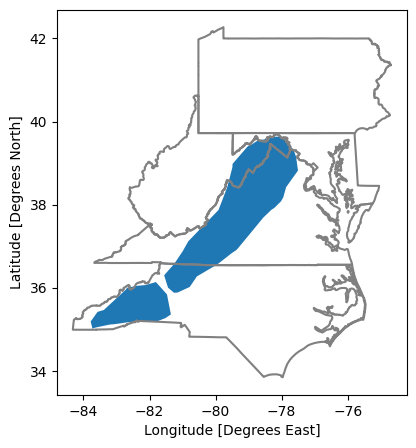

In [6]:
us_boundary_map = east.boundary.plot(figsize=(5, 5), color="Gray")
east_orchards_gdf.plot(ax = us_boundary_map)
plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Latitude [Degrees North]')

In [7]:
# Load Data
#ds_historical = get_nex_dataset(AVAILABLE_VARIABLES,["historical"])
ds_projection = get_nex_dataset(AVAILABLE_VARIABLES,["projection"])

In [47]:
#ds_historical_clipped = select_region(ds_historical, east_orchards_gdf)
ds_projection_clipped = select_region(ds_projection, east_orchards_gdf)

In [ ]:
# sample vis 
#ds_historical['tasmin'].isel(model = 0, time=0).plot()


Retrieve projected tasmin from NEX-GDDP-CMIP6 for existing orchards. 

In [48]:
train_da = ds_projection_clipped['tasmin'].sel(time=slice('2015-01-01T12:00:00.000000000', '2021-12-31T12:00:00.000000000'))
val_da = ds_projection_clipped['tasmin'].sel(time=slice('2022-01-01T12:00:00.000000000', '2022-12-31T12:00:00.000000000'))


# Will use ERA5 for test data
#test_da = ds_projection_clipped['tasmin'].sel(time=slice('2023-01-01T12:00:00.000000000', '2023-12-31T12:00:00.000000000'))

In [49]:
# resizing chunks to match with val, makes compute much longer, and hopefully more stable for running.
train_da = train_da.chunk({'model':20, 'scenario':4, 'time':2557, 'lat':10, 'lon':15})

In [50]:
train_da

<xarray.DataArray 'tasmin' (model: 20, scenario: 4, time: 2557, lat: 19, lon: 25)> Size: 389MB
dask.array<rechunk-merge, shape=(20, 4, 2557, 19, 25), dtype=float32, chunksize=(20, 4, 2557, 10, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 152B 35.12 35.38 35.62 ... 39.12 39.38 39.62
  * model        (model) <U10 800B 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario     (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time         (time) datetime64[ns] 20kB 2015-01-01T12:00:00 ... 2021-12-3...
  * lon          (lon) float64 200B -83.62 -83.38 -83.12 ... -77.88 -77.62
    spatial_ref  int32 4B 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        near-surface (usually, 2 meter) minimum air temperature; ...
    long_name:      Daily Near-Surface Minimum Air Temperature
    standard_name:  air_temperature
    units:          K

# Dask Dataframe

Notes: 
- I noticed that when a dask client is running, that parallel computing is performed for the operation.
- might get issues with deserializing, so need to upgrade msgpack to latest version
    - https://github.com/dask/distributed/issues/8038

In [51]:
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.to_dask_dataframe.html
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    train_df = train_da.to_dask_dataframe(['lat', 'model', 'scenario', 'time', 'lon'])
    train_df = train_df.compute()

train_df = train_df.dropna()

#train_df.to_csv(f"../data/train/dask_train_{east}_tasmin_CMIP6_projections.csv")

KilledWorker: Attempted to run task ('repartitiontofewer-2616e6d263f443e42d586ba58e8899b5', 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:51339. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
# More stable:
train_df = train_da.to_dataframe(name = 'tsmin_df') 
train_df.dropna(inplace = True)
train_df = train_df.reset_index('time')

In [ ]:
val_df = val_da.to_dask_dataframe(['lat', 'model', 'scenario', 'time', 'lon'])
val_df = val_df.compute()
val_df = val_df.dropna()


In [ ]:
# Export data to disk
region = 'east'
train_df.to_csv(f"../data/train/train_{east}_tasmin_CMIP6_projections.csv")
val_df.to_csv(f"../data/val/val_{east}_tasmin_CMIP6_projections.csv")


Resampling:

In [ ]:
# Perform Groupby
# https://examples.dask.org/dataframes/02-groupby.html

train_df_gb = train_df.groupby(train_df['time'].dt.year)['tasmin'].mean()

In [ ]:
plt.plot(train_df_gb)
plt.xlabel('year')
plt.ylabel('tsmin_df (Kelvin)')
plt.title('ACCESS-CM2 - tsmin_df ')

## Clean-up

In [45]:
# when ready to shutdown cluster
#client.shutdown()